In [1]:
import pandas as pd
import numpy as np
import time
from utils import *

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/rohitgundakalli/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [22]:
class MultiNaiveBayes():
    def __init__(self, positive_train_percentage, negative_train_percentage, positive_test_percentage, negative_test_percentage, alpha):
        self.positive_train_percentage = positive_train_percentage
        self.negative_train_percentage = negative_train_percentage

        self.positive_test_percentage = positive_test_percentage
        self.negative_test_percentage = negative_test_percentage
        
        self.alpha = alpha
        
        (self.pos_train, self.neg_train, self.vocab) = load_training_set(self.positive_train_percentage, self.negative_train_percentage)
        (self.pos_test,  self.neg_test) = load_test_set(self.positive_test_percentage, self.negative_test_percentage)
        
        self.pos_train_df = pd.DataFrame(self.pos_train)
        self.neg_train_df = pd.DataFrame(self.neg_train)

        len_pos_train_reviews = len(self.pos_train_df)
        len_neg_train_reviews = len(self.neg_train_df)
        len_train_df = len_pos_train_reviews + len_neg_train_reviews

        self.pos_class_probability = len_pos_train_reviews/len_train_df
        self.neg_class_probability = len_neg_train_reviews/len_train_df


        self.pos_test_df = pd.DataFrame(self.pos_test)
        self.neg_test_df = pd.DataFrame(self.neg_test)

        len_pos_test_reviews = len(self.pos_test_df)
        len_neg_test_reviews = len(self.neg_test_df)
        len_test_df = len_pos_test_reviews + len_neg_test_reviews
        
        # Convert the vocabulary (type : set) to numpy array.

        self.vocab_arr=np.array(list(self.vocab))
        self.vocab_arr.sort()

        self.total_vocabulary = len(self.vocab_arr)

        self.probability_matrix = pd.DataFrame(np.zeros((self.total_vocabulary, 2)),index = self.vocab_arr, columns=['occurance_in_pos_reviews','occurance_in_neg_reviews'])

        self.total_words_in_pos_rev_word_matrix=0
        self.total_words_in_neg_rev_word_matrix=0
        
    def train(self):
        start_time = time.time()
        for row in self.pos_train_df.itertuples():
        #     row_number= row.Index
            row = pd.DataFrame(row)
            words=row[1::].value_counts(dropna=True) # row[0] is index, so excluding it.
            for word, count in words.items():
                word = word[0]  # word is of the form ('movie',) -> converting this to 'movie'
                self.probability_matrix.loc[word]['occurance_in_pos_reviews']+=count
                self.total_words_in_pos_rev_word_matrix+=count

        for row in self.neg_train_df.itertuples():
        #     row_number= row.Index
            row = pd.DataFrame(row)
            words=row[1::].value_counts(dropna=True) # row[0] is index, so excluding it.
            for word, count in words.items():
                word = word[0]                                   
                self.probability_matrix.loc[word]['occurance_in_neg_reviews']+=count
                self.total_words_in_neg_rev_word_matrix+=count
        end_time = time.time()
        print('Training time: {}'.format(end_time-start_time))
        
    def predict(self, instance, alpha):
        instance = instance.dropna()

        temp_p = instance[0].apply(lambda x: self.probability_matrix['occurance_in_pos_reviews'].get(x,0.0))
        pos_probability = self.pos_class_probability*(((temp_p+self.alpha)/(self.total_words_in_pos_rev_word_matrix + self.total_vocabulary*self.alpha)).prod())

        temp_n = instance[0].apply(lambda x: self.probability_matrix['occurance_in_neg_reviews'].get(x,0.0))
        neg_probability = self.neg_class_probability*(((temp_n+self.alpha)/(self.total_words_in_neg_rev_word_matrix + self.total_vocabulary*self.alpha)).prod())

        if pos_probability>=neg_probability:
            return "POSITIVE"
        else:
            return "NEGATIVE"

    def predict_log_trick(self, instance, alpha):
        instance = instance.dropna()

        temp_p = instance[0].apply(lambda x: self.probability_matrix['occurance_in_pos_reviews'].get(x,0.0))
        pos_probability = np.log(self.pos_class_probability) + (np.log((temp_p+self.alpha)/(self.total_words_in_pos_rev_word_matrix + self.total_vocabulary*self.alpha))).sum()

        temp_n = instance[0].apply(lambda x: self.probability_matrix['occurance_in_neg_reviews'].get(x,0.0))
        neg_probability = np.log(self.neg_class_probability) + (np.log((temp_n+self.alpha)/(self.total_words_in_pos_rev_word_matrix + self.total_vocabulary*self.alpha))).sum()

        if pos_probability>=neg_probability:
            return "POSITIVE"
        else:
            return "NEGATIVE"
        
    def test(self, pos_test_set, neg_test_set):
        correct_predictions = 0
        tp = 0
        tn = 0
        fp = 0
        fn = 0

        start_time = time.time()
        for row in pos_test_set.itertuples():

            if self.predict(pd.DataFrame(row)[1::],alpha) == "POSITIVE":
                correct_predictions+=1
                tp+=1
            else:
                fn+=1


        for row in neg_test_set.itertuples():
            if self.predict(pd.DataFrame(row)[1::],alpha) == "NEGATIVE":
                correct_predictions+=1
                tn+=1
            else:
                fp+=1

        end_time = time.time()
        print('\nPrediction (without log trick) time: {}'.format(end_time-start_time))

        print('Correct predictions {} out of {}'.format(correct_predictions,(len(pos_test_set)+len(neg_test_set))))
        print('Accuracy : {}'.format(correct_predictions/(len(pos_test_set)+len(neg_test_set))))
        accuracy = correct_predictions/(len(pos_test_set)+len(neg_test_set))
        confusion = np.array([[tp,fn],[fp,tn]])
        print('Confusion Matrix')
        print(confusion)
        precision = tp/(tp+fp)
        recall = tp/(tp+fn)
        print('Precision : {}'.format(precision))
        print('Recall : {}\n'.format(recall))
        
        return accuracy, precision, recall
    
    def test_using_log(self, pos_test_set, neg_test_set):
        correct_predictions = 0
        tp = 0
        tn = 0
        fp = 0
        fn = 0

        start_time = time.time()
        for row in pos_test_set.itertuples():

            if self.predict_log_trick(pd.DataFrame(row)[1::], alpha) == "POSITIVE":
                correct_predictions+=1
                tp+=1
            else:
                fn+=1


        for row in neg_test_set.itertuples():
            if self.predict_log_trick(pd.DataFrame(row)[1::], alpha) == "NEGATIVE":
                correct_predictions+=1
                tn+=1
            else:
                fp+=1

        end_time = time.time()
        print('\nPrediction (with log trick) time: {}'.format(end_time-start_time))

        print('Correct predictions {} out of {}'.format(correct_predictions,(len(pos_test_set)+len(neg_test_set))))
        print('Accuracy : {}'.format(correct_predictions/(len(pos_test_set)+len(neg_test_set))))
        accuracy = correct_predictions/(len(pos_test_set)+len(neg_test_set))
        confusion = np.array([[tp,fn],[fp,tn]])
        print('Confusion Matrix')
        print(confusion)
        precision = tp/(tp+fp)
        recall = tp/(tp+fn)
        print('Precision : {}'.format(precision))
        print('Recall : {}\n'.format(recall))
        
        return accuracy, precision, recall

In [23]:
positive_train_percentage = 0.2
negative_train_percentage = 0.2

positive_test_percentage  = 0.2
negative_test_percentage  = 0.2

alpha = 10#**-5

mnb = MultiNaiveBayes(positive_train_percentage, negative_train_percentage, positive_test_percentage, negative_test_percentage, alpha)

In [24]:
mnb.train()

Training time: 11.088065147399902


In [25]:
mnb.test(mnb.pos_test_df, mnb.neg_test_df)


Prediction (without log trick) time: 5.855458974838257
Correct predictions 3296 out of 4913
Accuracy : 0.6708731935680847
Confusion Matrix
[[2224  283]
 [1334 1072]]
Precision : 0.6250702641933671
Recall : 0.8871160749900279



(0.6708731935680847, 0.6250702641933671, 0.8871160749900279)

In [28]:
mnb.test_using_log(mnb.pos_test_df, mnb.neg_test_df)


Prediction (with log trick) time: 6.175869941711426
Correct predictions 3793 out of 4913
Accuracy : 0.772033380826379
Confusion Matrix
[[1637  870]
 [ 250 2156]]
Precision : 0.8675145733969264
Recall : 0.6529716792979657



(0.772033380826379, 0.8675145733969264, 0.6529716792979657)

In [26]:
# Q2 - Laplace smoothing 
# Calculating metrics using various alpha values, and using predict_log_trick to calculate probabilites.
alpha_values = [0.0001,0.001,0.01,0.1,1,10,100,1000]
accuracies = []

for alpha in alpha_values:
    print('Alpha value: {}'.format(alpha))
    mnb.alpha = alpha
    
    accuracy, precision, recall = mnb.test(mnb.pos_test_df, mnb.neg_test_df)
    accuracies.append(accuracy)

Alpha value: 0.0001

Prediction (without log trick) time: 5.746686935424805
Correct predictions 3037 out of 4913
Accuracy : 0.6181559128841848
Confusion Matrix
[[2112  395]
 [1481  925]]
Precision : 0.5878096298357918
Recall : 0.8424411647387315

Alpha value: 0.001

Prediction (without log trick) time: 5.745786905288696
Correct predictions 3109 out of 4913
Accuracy : 0.6328109098310605
Confusion Matrix
[[2132  375]
 [1429  977]]
Precision : 0.5987082280258355
Recall : 0.8504188272836058

Alpha value: 0.01

Prediction (without log trick) time: 5.8487749099731445
Correct predictions 3183 out of 4913
Accuracy : 0.6478729900264604
Confusion Matrix
[[2149  358]
 [1372 1034]]
Precision : 0.610337972166998
Recall : 0.8571998404467491

Alpha value: 0.1

Prediction (without log trick) time: 5.829588890075684
Correct predictions 3231 out of 4913
Accuracy : 0.6576429879910441
Confusion Matrix
[[2150  357]
 [1325 1081]]
Precision : 0.6187050359712231
Recall : 0.8575987235739928

Alpha value: 1

Pr

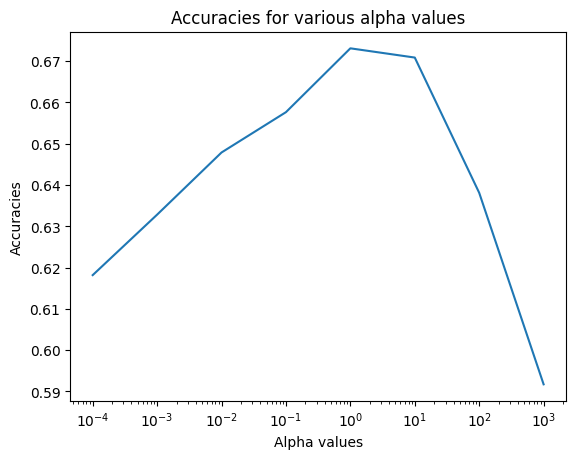

In [27]:
# Plot accuracy vs alpha values plot
import matplotlib.pyplot as plt


plt.plot(alpha_values, accuracies)
  
plt.xlabel('Alpha values')
plt.ylabel('Accuracies')
plt.xscale("log")
  
plt.title('Accuracies for various alpha values')
  
# function to show the plot
plt.show()

In [29]:
# Q2 - Laplace smoothing 
# Calculating metrics using various alpha values, and using predict_log_trick to calculate probabilites.
alpha_values = [0.0001,0.001,0.01,0.1,1,10,100,1000]
accuracies = []

for alpha in alpha_values:
    print('Alpha value: {}'.format(alpha))
    mnb.alpha = alpha
    
    accuracy, precision, recall = mnb.test_using_log(mnb.pos_test_df, mnb.neg_test_df)
    accuracies.append(accuracy)

Alpha value: 0.0001

Prediction (with log trick) time: 6.199474096298218
Correct predictions 3553 out of 4913
Accuracy : 0.7231833910034602
Confusion Matrix
[[1835  672]
 [ 688 1718]]
Precision : 0.7273087594133968
Recall : 0.7319505384922218

Alpha value: 0.001

Prediction (with log trick) time: 6.074954986572266
Correct predictions 3645 out of 4913
Accuracy : 0.741909220435579
Confusion Matrix
[[1883  624]
 [ 644 1762]]
Precision : 0.7451523545706371
Recall : 0.7510969285999203

Alpha value: 0.01

Prediction (with log trick) time: 6.042118072509766
Correct predictions 3792 out of 4913
Accuracy : 0.7718298392021168
Confusion Matrix
[[1964  543]
 [ 578 1828]]
Precision : 0.7726199842643587
Recall : 0.7834064619066613

Alpha value: 0.1

Prediction (with log trick) time: 6.098731994628906
Correct predictions 3969 out of 4913
Accuracy : 0.8078567066965194
Confusion Matrix
[[2061  446]
 [ 498 1908]]
Precision : 0.8053927315357562
Recall : 0.8220981252493019

Alpha value: 1

Prediction (wit

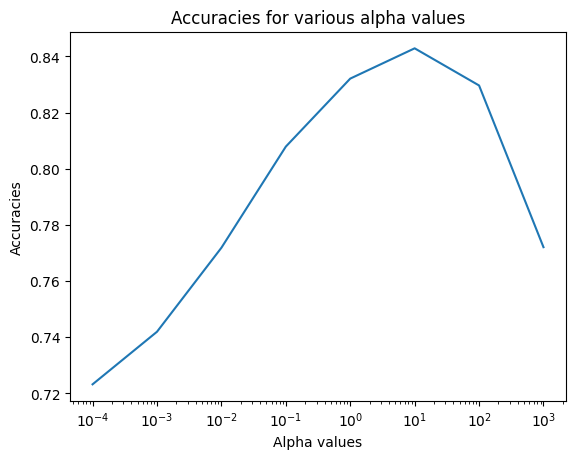

In [30]:
# Plot accuracy vs alpha values plot
import matplotlib.pyplot as plt


plt.plot(alpha_values, accuracies)
  
plt.xlabel('Alpha values')
plt.ylabel('Accuracies')
plt.xscale("log")
  
plt.title('Accuracies for various alpha values')
  
# function to show the plot
plt.show()